Import Dependencies

In [8]:
!python -V

Python 3.9.13


In [6]:
!sudo apt-get update -y
!sudo apt-get install python3.9

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [91.1 kB]
Hit:13 http:

In [7]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 2

update-alternatives: using /usr/bin/python3.9 to provide /usr/bin/python3 (python3) in auto mode


# Load Requirements

### Library and Gdrive

In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPooling2D

import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd
import numpy as np
from google.colab import output
import time
from IPython.display import HTML, display
from keras.preprocessing.image import ImageDataGenerator


Mount Google Drive

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [ ]:
train_dir = '/content/drive/MyDrive/PlantVillage/TrainLeaves2/'
test_dir = '/content/drive/MyDrive/PlantVillage/TestLeaves2/'

# train_dir = 'D:/document/FEU/PlantVillage/Train/'

In [ ]:
# dataset = tf.keras.preprocessing.image_dataset_from_directory(
#     "/content/drive/MyDrive/PlantVillage/Train/",
#     seed=123,
#     # shuffle=false,
#     image_size=(IMAGE_SIZE,IMAGE_SIZE),
#     batch_size=BATCH_SIZE
# )
# dataset.class_names

In [13]:
class_names = [
  'Basella Alba (Basale)',
  'Muntingia Calabura (Jamaica Cherry-Gasagase)',
  'Plectranthus Amboinicus (Mexican Mint)',
  'Pongamia Pinnata (Indian Beech)',
  'Psidium Guajava (Guava)',
  'Syzygium Jambos (Rose Apple)',
  'ipil-ipil',
]

### Morphological Mask

In [11]:
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from google.colab.patches import cv2_imshow

def morphologicalMasking(image):
    processImg = segment_image(image)
    processImg = sharpen_image(processImg)
    processImg = cv2.cvtColor(processImg,cv2.COLOR_RGB2GRAY)
    processImg = cv2.threshold(processImg, 128, 255, cv2.THRESH_BINARY)[1]
    processImg = np.reshape(processImg,(256,256,1))
    return processImg

def create_mask_for_image(image):
    '''
    Utility Function to create segmented morphological masks
    '''
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([20, 40, 0])
    upper_hsv = np.array([95, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    # kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask


def segment_image(image):
    '''
    Utility Function to apply segmented morphological masks
    '''
    mask = create_mask_for_image(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output
 
def sharpen_image(image):
    '''
    Utility Function to sharpen processed images
    '''
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    # image_sharp = cv2.addWeighted(image, 1.5, image_blurred, 25.2, 0)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, 2, 0)
    return image_sharp
def increase_brightness(img, value=100):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img
# def convertImage(image):
#     h, w, c = image.shape
#     # append Alpha channel -- required for BGRA (Blue, Green, Red, Alpha)
#     image_bgra = np.concatenate([image, np.full((h, w, 1), 255, dtype=np.uint8)], axis=-1)
#     # create a mask where white pixels ([255, 255, 255]) are True
#     white = np.all(image == [255, 255, 255], axis=-1)
#     # change the values of Alpha to 0 for all the white pixels
#     image_bgra[white, -1] = 0
#     return np.array(image_bgra)
def convertImage(alpha):
    h, w = alpha.shape
    img = np.ones([h, w, 4], np.uint8) * (0, 0, 0, 255)
    img[:,:,3] = alpha
    return np.array(img)

    

def detect_ridges(image, sigma=1.0):
    grayscale_image =cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    ridge_filter = cv2.ximgproc.RidgeDetectionFilter_create(ddepth=cv2.CV_32FC1,ksize=5,scale=0.03)
    ridges = ridge_filter.getRidgeFilteredImage(grayscale_image)
    ridges = cv2.bitwise_not(ridges)
    ridges = cv2.cvtColor(ridges,cv2.COLOR_GRAY2RGBA)
    # ridges = convertImage(ridges)
    return ridges

def plot_images(*images,isRandom=True):
    plt.figure(figsize=(20, 10))
    n = len(images)
    if(n > 12):
      n = 12
    for i in range(n):
      rand = i
      if isRandom:
        rand=np.random.randint(0, n)
      ax = plt.subplot(3, 4, i + 1)
      plt.imshow(cv2.cvtColor(images[rand], cv2.COLOR_BGR2RGBA))


      plt.axis("off")

def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

def overlay(background, foreground):
    # normalize alpha channels from 0-255 to 0-1
    alpha_background = background[:,:,3] / 255.0
    alpha_foreground = foreground[:,:,3] / 255.0

    # set adjusted colors
    for color in range(0, 3):
        background[:,:,color] = alpha_foreground * foreground[:,:,color] + \
            alpha_background * background[:,:,color] * (1 - alpha_foreground)

    # set adjusted alpha and denormalize back to 0-255
    background[:,:,3] = (1 - (1 - alpha_foreground) * (1 - alpha_background)) * 255
    return background

def removeBlurr(img):

  # grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # canny
  canned = cv2.Canny(gray, 100, 200)

  # dilate to close holes in lines
  kernel = np.ones((5,5),np.uint8)
  mask = cv2.dilate(canned, kernel, iterations = 1)

  # find contours
  # Opencv 3.4, if using a different major version (4.0 or 2.0), remove the first underscore
  contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  if not contours:
      return None
  # find big contours
  biggest_cntr = None
  biggest_area = 0
  for contour in contours:
      area = cv2.contourArea(contour)
      if area > biggest_area:
          biggest_area = area
          biggest_cntr = contour

  # draw contours
  crop_mask = np.zeros_like(mask)
  cv2.drawContours(crop_mask, [biggest_cntr], -1, (255), -1)

  # fill in holes
  # inverted
  inverted = cv2.bitwise_not(crop_mask)

  # contours again
  contours, _ = cv2.findContours(inverted, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  if not contours:
      return None
  # find small contours
  small_cntrs = []
  for contour in contours:
      area = cv2.contourArea(contour)
      if area < 20000:
          small_cntrs.append(contour)

  # draw on mask
  cv2.drawContours(crop_mask, small_cntrs, -1, (255), -1)

  # opening + median blur to smooth jaggies
  crop_mask = cv2.erode(crop_mask, kernel, iterations = 1)
  crop_mask = cv2.dilate(crop_mask, kernel, iterations = 1)
  crop_mask = cv2.medianBlur(crop_mask, 5)

  # crop image
  crop = np.zeros_like(img)
  crop[crop_mask == 255] = img[crop_mask == 255]

  # show
  # cv2_imshow(img);
  # cv2_imshow(gray);
  # cv2_imshow(canned);
  # cv2_imshow(crop_mask);
  # cv2_imshow(crop);
  # cv2.waitKey(0);
  return crop


### Create Dataframe for file location

In [ ]:
train = []
SPECIES = class_names

for species_num, species in enumerate(SPECIES):
    for count, file in enumerate(os.listdir(os.path.join(train_dir, species + '/'))):
          train.append([train_dir + '/{}/{}'.format(species, file), species_num, species])
train_df = pd.DataFrame(train, columns=['file', 'species_num', 'species'])

print('Training Data Shape: ',train_df.shape)
train_df

Training Data Shape:  (388, 3)


,file,species_num,species
0,/content/drive/MyDrive/PlantVillage/TrainLeave...,0,Basella Alba (Basale)
1,/content/drive/MyDrive/PlantVillage/TrainLeave...,0,Basella Alba (Basale)
2,/content/drive/MyDrive/PlantVillage/TrainLeave...,0,Basella Alba (Basale)
3,/content/drive/MyDrive/PlantVillage/TrainLeave...,0,Basella Alba (Basale)
4,/content/drive/MyDrive/PlantVillage/TrainLeave...,0,Basella Alba (Basale)
...,...,...,...
383,/content/drive/MyDrive/PlantVillage/TrainLeave...,5,Syzygium Jambos (Rose Apple)
384,/content/drive/MyDrive/PlantVillage/TrainLeave...,5,Syzygium Jambos (Rose Apple)
385,/content/drive/MyDrive/PlantVillage/TrainLeave...,5,Syzygium Jambos (Rose Apple)
386,/content/drive/MyDrive/PlantVillage/TrainLeave...,5,Syzygium Jambos (Rose Apple)


In [ ]:
test = []
SPECIES = class_names
train_dir
for species_num, species in enumerate(SPECIES):
    for count, file in enumerate(os.listdir(os.path.join(test_dir, species + '/'))):
          test.append([test_dir + '/{}/{}'.format(species, file), species_num, species])
test_df = pd.DataFrame(test, columns=['file', 'species_num', 'species'])

print('Training Data Shape: ',test_df.shape)
test_df

Training Data Shape:  (51, 3)


,file,species_num,species
0,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
1,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
2,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
3,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
4,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
5,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
6,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
7,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
8,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)
9,/content/drive/MyDrive/PlantVillage/TestLeaves...,0,Basella Alba (Basale)


In [ ]:
def progress(value, max=100):
    return HTML("""
        <div style="display:flex; align-items:center">
          <h3 style="width:5rem">
          {progress:.2f}
          </h3>
          <progress
              value='{value}'
              max='{max}',
              style='width: 100%;padding-top:2rem;margin-top:1rem'
          >
              {value}
          </progress>
        </div>
    """.format(value=value, max=max,progress=100 * (value / float(max))))




### load Image to memory

**Train Leaves**

(256, 256, 3)


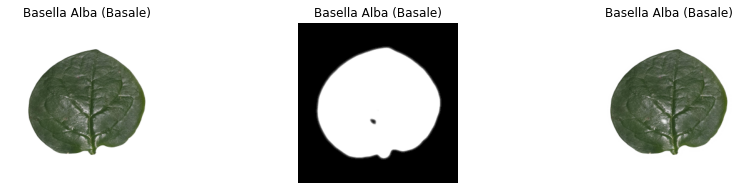

In [ ]:
import PIL.Image
from PIL import Image

Originalimg = []
Masked = []
Ridged = []
preProcessed = []
preProcessedLabels = []
l = len(train_df['file'])
out = display(progress(0, l), display_id=True)
    
for i, file in enumerate(train_df['file']):
    out.update(progress(i, l))
    img = cv2.imread(file)
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    processImg = morphologicalMasking(img)
    if(i == 2):
      Masked = processImg
    #cv2_imshow(cv2.cvtColor(processImg, cv2.COLOR_BGR2RGB))
    # x_train.append(processImg)
    processImg = np.concatenate((np.array(img),np.array(processImg)),axis=2)
    rgb = rgba2rgb(np.array(processImg))
    # ridges = detect_ridges(processImg)
    # ridges = np.array(ridges)
    if(i == 2):
      Originalimg = img
      # Ridged = ridges
    # processImg = overlay(processImg,ridges)
    preProcessed.append(rgb)
    preProcessedLabels.append(train_df['species_num'][i])

preProcessed = np.array(preProcessed)
# x_train = np.reshape(x_train,x_train.shape + (1,))
Originalimg = np.array(Originalimg)
Masked = np.array(Masked)
print(preProcessed[2].shape) 
plot_images(Originalimg,Masked,preProcessed[2],isRandom=False)
# b= cv2.cvtColor(b,cv2.COLOR_BGR2GRAY)
# im.save("/content/drive/MyDrive/PlantVillage/ridges.png")



In [ ]:
print(len(preProcessed))

In [ ]:
# print(preProcessed.shape)
plt.figure(figsize=(20, 10))
for i in range(12):
  rand=np.random.randint(0, preProcessed.shape[0])
  # print(rand)
  ax = plt.subplot(3, 4, i + 1)
  plt.imshow(cv2.cvtColor(preProcessed[rand], cv2.COLOR_BGR2RGBA))

  plt.title(class_names[train_df['species_num'][rand]])
  plt.axis("off")
# plot_images(x_train)

In [ ]:
preProcessed.shape

In [ ]:
TestpreProcessed = []
TestpreProcessedLabels = []
l = len(test_df['file'])
out = display(progress(0, l), display_id=True)
    
for i, file in enumerate(test_df['file']):
    out.update(progress(i, l))
    img = cv2.imread(file)
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    processImg = segment_image(img)
    processImg = sharpen_image(processImg)
    processImg = cv2.cvtColor(processImg,cv2.COLOR_RGB2GRAY)
    processImg = np.reshape(processImg,(256,256,1))
    processImg = np.concatenate((np.array(img),np.array(processImg)),axis=2)
    rgb = rgba2rgb(np.array(processImg))
    TestpreProcessed.append(rgb)
    TestpreProcessedLabels.append(train_df['species_num'][i])

TestpreProcessed = np.array(TestpreProcessed)
# x_train = np.reshape(x_train,x_train.shape + (1,))
# b= cv2.cvtColor(b,cv2.COLOR_BGR2GRAY)
# im.save("/content/drive/MyDrive/PlantVillage/ridges.png"


In [ ]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(preProcessed,train_df['species_num'] ,
                                                    # stratify=labels, 
                                                    test_size=0.25)

# x_train = preProcessed
# y_train = preProcessedLabels 

# x_test, x_Pred, y_test, y_Pred = train_test_split(TestpreProcessed,TestpreProcessedLabels,
#                                                     # stratify=labels, 
#                                                     test_size=0.25)



In [ ]:
# from PIL import Image
# PredName = np.array(y_Pred)
# for i, plant in enumerate(x_Pred):
#   print(i,end=' ')
#   im = Image.fromarray(plant)
#   im.save(f'/content/drive/MyDrive/PlantVillage/Identify/plant3/{class_names[PredName[i]]}/{class_names[PredName[i]]}{i}.jpg')

In [ ]:
print(x_train.shape)
print(len(y_train))

print(x_test.shape)
print(len(y_test))

y_train = np.array(y_train)
y_test = np.array(y_test)

(291, 256, 256, 3)
291
(97, 256, 256, 3)
97


In [ ]:
# y_trainDF = pd.DataFrame(y_train)
# y_trainDF

### Data Augmentation


In [ ]:
def dataGenerator(x,y,batch,datagen):
  
  datagen.fit(x)

  train_test_generator = datagen.flow(x,y, batch_size=batch)
  aug_x_ = []
  aug_y_ = []
  for j in range(len(train_test_generator)):

    # convert to unsigned integers for plotting
    for i in range(4):
      data = next(train_test_generator)
      image = data[0].astype('uint8')
      title = data[1]
      for i in range(len(image)):
        # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
        img = np.squeeze(image[i])
        aug_x_.append(img)
        aug_y_.append(title[i])

  aug_x_ = np.array(aug_x_)
  aug_y_ = np.array(aug_y_)

  aug_x_ = np.concatenate((aug_x_,x),axis=0)
  aug_y_ = np.concatenate((aug_y_,y),axis=0)
  return aug_x_, aug_y_

Train

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, zoom_range = 0.2,
                             horizontal_flip=True, vertical_flip=True, fill_mode='constant',cval=255)

In [ ]:
aug_x_train, aug_y_train = dataGenerator(x_train,y_train,BATCH_SIZE,datagen)

In [ ]:
print(aug_x_train.shape)
print(aug_y_train.shape)


(1455, 256, 256, 3)
(1455,)


Test

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, zoom_range = 0.2,
                             horizontal_flip=True, vertical_flip=True, fill_mode='constant',cval=255)

In [ ]:
aug_x_test, aug_y_test = dataGenerator(x_test,y_test,BATCH_SIZE,datagen)

In [ ]:
print(aug_x_test.shape)
print(aug_y_test.shape)
print(y_test.shape)

(485, 256, 256, 3)
(485,)
(97,)


In [ ]:
# plotting images
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

  # convert to unsigned integers for plotting
  data = next(train_generator)
  image = data[0].astype('uint8')
  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image[0])
  title = data[1]

  # plot raw pixel data
  ax[i].imshow(image)
  ax[i].set_title(class_names[title[0]])
  ax[i].axis('off')

# CNN Training

In [ ]:
input_shape = x_train.shape
# print(input_shape)
# print(labels.value_counts())
# print(y_train)
# print(type(y_train))

In [ ]:
# input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 1)
n_classes = 6
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size = (3,3), input_shape=input_shape),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64, kernel_size = (3,3)),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Conv2D(64,  kernel_size = (3,3)),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3)),
    layers.Activation('relu'),

    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64,name="featureLayer"),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])



In [ ]:
model.build(input_shape=input_shape)

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(aug_x_train,aug_y_train, batch_size=32, epochs = 10,validation_data = (aug_x_test,aug_y_test), verbose = 1)
# history = model.fit(datagen.flow(x_train,y_train, batch_size=BATCH_SIZE), 
#                               steps_per_epoch=x_train.shape[0]//BATCH_SIZE, 
#                               epochs = 10,
#                               validation_data = (x_test,y_test),
#                               validation_steps = x_test.shape[0]//BATCH_SIZE, 
#                               verbose = 1)

Epoch 1/10
46/46 [==============================] - 18s 119ms/step - loss: 1.3767 - accuracy: 0.4708 - val_loss: 0.9461 - val_accuracy: 0.6062
Epoch 2/10
46/46 [==============================] - 4s 95ms/step - loss: 0.6519 - accuracy: 0.7485 - val_loss: 0.6696 - val_accuracy: 0.7340
Epoch 3/10
46/46 [==============================] - 4s 95ms/step - loss: 0.2876 - accuracy: 0.8928 - val_loss: 0.3915 - val_accuracy: 0.8680
Epoch 4/10
46/46 [==============================] - 5s 100ms/step - loss: 0.2630 - accuracy: 0.9107 - val_loss: 0.2933 - val_accuracy: 0.9237
Epoch 5/10
46/46 [==============================] - 4s 96ms/step - loss: 0.2640 - accuracy: 0.9065 - val_loss: 0.4277 - val_accuracy: 0.8866
Epoch 6/10
46/46 [==============================] - 4s 98ms/step - loss: 0.2033 - accuracy: 0.9333 - val_loss: 0.3637 - val_accuracy: 0.8639
Epoch 7/10
46/46 [==============================] - 4s 96ms/step - loss: 0.1841 - accuracy: 0.9333 - val_loss: 0.2732 - val_accuracy: 0.9072
Epoch 8/10

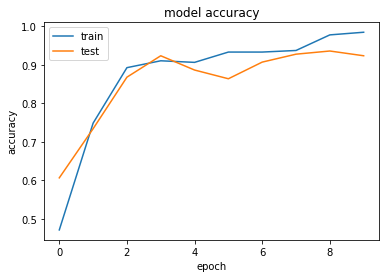

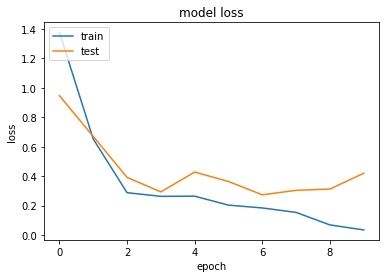

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_11 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_77 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 activation_26 (Activation)  (None, 254, 254, 16)      0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_78 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 activation_27 (Activation)  (None, 125, 125, 32)      0         
                                                     

# Load Testing Data

In [14]:
from sklearn.utils import shuffle
import numpy as np


identify = []
identifyDir = '/content/drive/MyDrive/PlantVillage/TrainLeaves2/'
# identifyDir = '/content/drive/MyDrive/PlantVillage/Test/'
# identifyDir = '/content/drive/MyDrive/PlantVillage/Identify/augTestLeaves2/'
# identifyDir = 'D:/document/FEU/PlantVillage/Identify/'

toTest = class_names
SPECIES =  ['Ipil-ipil']
print(SPECIES)
fileName = []
for species_num, species in enumerate(SPECIES):
    for file in os.listdir(os.path.join(identifyDir, species + '/')):
        fileName.append(file)
        identify.append([identifyDir + '/{}/{}'.format(species, file), species_num, species])
        
identify_df = pd.DataFrame(identify, columns=['file', 'species_num', 'species'])

print('Testing Data Shape: ',identify_df.shape)

['Ipil-ipil']
Testing Data Shape:  (55, 3)


**Without Filter**

In [15]:
x_identify = []
for i in range(len(identify)):
    img = cv2.imread(identify_df['file'][i])
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    x_identify.append(np.array(img))


x_identify = np.array(x_identify)
# x_identify = np.reshape(x_identify,x_identify.shape + (0,))  
identify_labels = identify_df['species']
x_identify.shape

(55, 256, 256, 3)

### Filters

**With Filter**

**Filter Type 1**

In [ ]:
x_identify = []
for i in range(len(identify)):
    img = cv2.imread(identify_df['file'][i])
    
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    processImg = morphologicalMasking(img)

    #cv2_imshow(cv2.cvtColor(processImg, cv2.COLOR_BGR2RGB))
    # x_train.append(processImg)
    processImg = np.concatenate((np.array(img),np.array(processImg)),axis=2)
    blurr = removeBlurr(processImg)
    if blurr is not None:
        processImg = blurr
    processImg = rgba2rgb(np.array(processImg))
    # ridges = detect_ridges(rgb)
    x_identify.append(processImg)



x_identify = np.array(x_identify)
print(len(identify))
# x_identify = np.reshape(x_identify,x_identify.shape + (1,))  
identify_labels = identify_df['species']
identify_labels = np.array(identify_labels)

55


**Filter Type 2**

In [17]:
x_identify = []

for i in range(len(identify)):
    img = cv2.imread(identify_df['file'][i])
    img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
    # processImg = removeBlurr(img)
    processImg = morphologicalMasking(img)
    #cv2_imshow(cv2.cvtColor(processImg, cv2.COLOR_BGR2RGB))
    # x_train.append(processImg)

    processImg = np.concatenate((np.array(img),np.array(processImg)),axis=2)
    rgb = rgba2rgb(np.array(processImg))
    # ridges = detect_ridges(rgb)
    x_identify.append(rgb)



x_identify = np.array(x_identify)
print(len(identify))
# x_identify = np.reshape(x_identify,x_identify.shape + (1,))  
identify_labels = identify_df['species']
identify_labels = np.array(identify_labels)

55


In [ ]:
datagen = ImageDataGenerator(rotation_range=360, zoom_range = 0.2,
                              horizontal_flip=True, vertical_flip=True, fill_mode='constant',cval=255)
aug_x_identify , aug_y_identify = dataGenerator(x_identify,identify_labels,8,datagen)
# from PIL import Image
# identify_l = identify_df['species_num']
# for i, plant in enumerate(aug_x_identify):
#   plants = plant[:,:,::-1]
#   image = Image.fromarray(plants.astype('uint8'), 'RGB')


#   image.save(f'/content/drive/MyDrive/PlantVillage/augTestLeaves2/{aug_y_identify[i]}/{aug_y_identify[i]}{i}.jpg')

In [ ]:
plt.figure(figsize=(20, 20))
length = len(x_identify)
if length > 20:
  length = 20
for i in range(length):
  ax = plt.subplot(5, 4, i + 1)
  plt.imshow(cv2.cvtColor(x_identify[i], cv2.COLOR_BGR2RGBA))
  plt.axis("off")
  # plt.title(aug_y_identify[i])

# CNN Prediction

**CNN Prediction**

In [ ]:
from pprint import pprint
batch_prediction = model.predict(x_identify)
predictionList = {}
count = 0
for i in batch_prediction:
  # print("predicted label:",class_names[np.argmax(i)]," ",i[np.argmax(i)])
  if(class_names[np.argmax(i)] not in predictionList):
    predictionList[class_names[np.argmax(i)]] = 1
  else:
    predictionList[class_names[np.argmax(i)]] += 1

pprint(predictionList)    
# scores = model.evaluate(x_test,y_test)

{'Basella Alba (Basale)': 1, 'Muntingia Calabura (Jamaica Cherry-Gasagase)': 1}


In [ ]:
from tensorflow import keras

model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('featureLayer').output)

In [ ]:
feat_train = model_feat.predict(aug_x_train)
print(feat_train.shape)

(1455, 64)


In [ ]:
# feat_test = model_feat.predict(x_test)
feat_test = model_feat.predict(x_identify)
print(feat_test.shape)

(28, 64)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
# from sklearn.inspection import DecisionBoundaryDisplay
import pylab as pl
import numpy as np



scores = []
for i in range(3,15):
  knn = KNeighborsClassifier(n_neighbors=i)

  knn.fit(feat_train,aug_y_train)

  score = knn.score(model_feat.predict(aug_x_test),aug_y_test)
  scores.append(score)
  print("neighbors: ",i," score: ",score)


plt.plot(range(3,15),scores)
plt.xlabel('Vallue of K for KNN')
plt.ylabel('Testing Accuracy')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(feat_train,aug_y_train)

# score = knn.score(feat_test,y_test)
# print(score)
predictionList = {}

prediction = knn.predict(feat_test)
proba = knn.predict_proba(feat_test)
for i,pred in enumerate(prediction):
  probability = max(proba[i])
  if probability > 0.5:
    print("The prediction for this image is: ", class_names[pred]," probability: ",probability)
  else:
    print("Not Sure")
  if(class_names[pred] not in predictionList):
    predictionList[class_names[pred]] = 1
  else:
    predictionList[class_names[pred]] += 1

pprint(predictionList)


The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Pongamia Pinnata (Indian Beech)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  0.6
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guava)  probability:  1.0
The prediction for this image is:  Psidium Guajava (Guav

In [ ]:
trainingFeatures = model_feat.predict(x_train)
npytrain = np.array(y_train)
rows = []

for  features in trainingFeatures:
    rows.append(['plant'] + features)

featuresdf = pd.DataFrame(rows, columns=['plants'] + [f'Unit {i+1}' for i in range(64)])  
featuresdf

# Models Location

In [ ]:
fileName = "3747659RGBaug50_leafv4"
Path = "/content/drive/MyDrive/PlantVillage/Models/"

CNNModel = f'{fileName}.h5'
CNNModelPath = f'{Path}/CNN/{CNNModel}'

kNNModel = f'{fileName}.pkl'
kNNModelPath = f'{Path}/kNN/{kNNModel}'

preprocessedArray = f'{fileName}.npy'
preprocessedArrayPath = f'{Path}/preprocessed/{preprocessedArray}'

TestpreprocessedArray = f'{fileName}.npy'
TestpreprocessedArrayPath = f'{Path}/TestpreProcessed/{preprocessedArray}'

x_trainArray = f'{fileName}.npy'
x_trainArrayPath = f'{Path}/x_train/{x_trainArray}'

aug_x_trainArray = f'{fileName}.npy'
aug_x_trainArrayPath = f'{Path}/aug_x_train/{aug_x_trainArray}'

x_testArray = f'{fileName}.npy'
x_testArrayPath = f'{Path}/x_test/{x_testArray}'

aug_x_testArray = f'{fileName}.npy'
aug_x_testArrayPath = f'{Path}/aug_x_test/{aug_x_testArray}'

y_trainArray = f'{fileName}.csv'
y_trainArrayPath = f'{Path}/y_train/{y_trainArray}'

aug_y_trainArray = f'{fileName}.npy'
aug_y_trainArrayPath = f'{Path}/aug_y_train/{aug_y_trainArray}'

y_testArray = f'{fileName}.csv'
y_testArrayPath = f'{Path}/y_test/{y_testArray}'

aug_y_testArray = f'{fileName}.npy'
aug_y_testArrayPath = f'{Path}/aug_y_test/{aug_y_testArray}'

### Save Models

In [ ]:
import os.path
import joblib
replace = False
save = [
        'CNN',
        'kNN',
        # 'preprocessed',
        # 'TestpreProcessed',
        'x_train',
        'aug_x_train',
        'x_test',
        'aug_x_test',
        'y_train',
        'aug_y_train',
        'y_test',
        'aug_y_test'
        ]

# CNN
if 'CNN' in save and os.path.isfile(CNNModelPath) is replace:
  print("saved CNN")
  model.save(CNNModelPath)

# kNN
if 'kNN' in save and os.path.isfile(kNNModelPath) is replace:
  print("saved kNN")
  joblib.dump(knn, kNNModelPath)  

# preprocessed
if 'preprocessed' in save and os.path.isfile(preprocessedArrayPath) is replace :
  print("saved preprocessed")
  np.save(preprocessedArrayPath, preProcessed)

# testpreprocessed
if 'TestpreProcessed' in save and os.path.isfile(TestpreprocessedArrayPath) is replace :
  print("saved testpreprocessed")
  np.save(TestpreprocessedArrayPath, TestpreProcessed)

# x_train
if 'x_train' in save and os.path.isfile(x_trainArrayPath) is replace:
  print("saved x_train")
  np.save(x_trainArrayPath, x_train)

# aug_x_train
if 'aug_x_train' in save and os.path.isfile(aug_x_trainArrayPath) is replace:
  print("saved aug_x_train")
  np.save(aug_x_trainArrayPath, aug_x_train)

# x_test
if 'x_test' in save and os.path.isfile(x_testArrayPath) is replace:
  print("saved x_test")
  np.save(x_testArrayPath, x_test)

# aug_x_test
if 'aug_x_test' in save and os.path.isfile(aug_x_testArrayPath) is replace:
  print("saved aug_x_test")
  np.save(aug_x_testArrayPath, aug_x_test)

# y_train
if 'y_train' in save and os.path.isfile(y_trainArrayPath) is replace:
  print('save y_train')
  y_trainDF = pd.DataFrame(y_train)
  y_trainDF.to_csv(y_trainArrayPath)

# aug_y_train
if 'aug_y_train' in save and os.path.isfile(aug_y_trainArrayPath) is replace:
  print("saved aug_y_train")
  y_trainDF = pd.DataFrame(aug_y_train)
  y_trainDF.to_csv(aug_y_trainArrayPath)

# y_test
if 'y_test' in save and os.path.isfile(y_testArrayPath) is replace:
  print('save y_test')
  y_testDF = pd.DataFrame(y_test)
  y_testDF.to_csv(y_testArrayPath)

# aug_y_test
if 'aug_y_test' in save and os.path.isfile(aug_y_testArrayPath) is replace:
  print("saved aug_y_test")
  y_testDF = pd.DataFrame(aug_y_test)
  y_testDF.to_csv(aug_y_testArrayPath)

saved CNN
saved kNN
saved x_train
saved aug_x_train
saved x_test
saved aug_x_test
save y_train
saved aug_y_train
save y_test
saved aug_y_test


### Load Models


In [ ]:
import os.path
import joblib
from tensorflow.keras.models import load_model
from tensorflow import keras


load = [
        'CNN',
        'kNN',
        # 'preprocessed',
        # 'TestpreProcessed',
        # 'x_train',
        'aug_x_train',
        # 'x_test',
        'aug_x_test',
        # 'y_train',
        'aug_y_train',
        # 'y_test',
        'aug_y_test'
        ]
model = None
model_feat = None
knn = None
preProcessed = None
x_train = None
aug_x_train = None
x_test = None
aug_x_test = None
y_train = None
aug_y_train = None
y_test = None
aug_y_test = None

if 'CNN' in load:
  model = load_model(CNNModelPath)
  model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('featureLayer').output)
  print('CNN loaded')

if 'kNN' in load:
  knn = joblib.load(kNNModelPath)
  print('kNN loaded')

if 'preprocessed' in load:
  preProcessed = np.load(preprocessedArrayPath)
  print('preprocessed loaded')

if 'TestpreProcessed' in load:
  TestpreProcessed = np.load(TestpreprocessedArrayPath)
  print('TestpreProcessed loaded')

if 'x_train' in load:
  x_train = np.load(x_trainArrayPath)
  print('x_train loaded')

if 'aug_x_train' in load:
  aug_x_train = np.load(aug_x_trainArrayPath)
  print('aug_x_train loaded')

if 'x_test' in load:
  x_test = np.load(x_testArrayPath)
  print('x_test loaded')

if 'aug_x_test' in load:
  aug_x_test = np.load(aug_x_testArrayPath)
  print('aug_x_test loaded')  

if 'y_train' in load:
  y_train = pd.read_csv(y_trainArrayPath,index_col=0)
  y_train = y_train.squeeze()
  print('y_train loaded')

if 'aug_y_train' in load:
  aug_y_train = pd.read_csv(aug_y_trainArrayPath,index_col=0)
  aug_y_train = aug_y_train.squeeze()
  print('aug_y_train loaded')

if 'y_test' in load:
  y_test = pd.read_csv(y_testArrayPath,index_col=0)
  y_test = y_test.squeeze()
  print('y_test loaded')

if 'aug_y_test' in load:
  aug_y_test = pd.read_csv(aug_y_testArrayPath,index_col=0)
  aug_y_test = aug_y_test.squeeze()
  print('aug_y_test loaded')

CNN loaded
kNN loaded
aug_x_train loaded
aug_x_test loaded
aug_y_train loaded
aug_y_test loaded



# Testing

In [ ]:
model.summary()
scores = model.evaluate(x_test,y_test)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [ ]:
from tensorflow import keras

model_feat = keras.Model(inputs=model.input,outputs=model.get_layer('featureLayer').output)
feat_test = model_feat.predict(x_identify)
# score = knn.score(model_feat.predict(x_test),y_test)
prediction = knn.predict(feat_test)
proba = knn.predict_proba(feat_test)
for i,pred in enumerate(prediction):
  probability = max(proba[i])
  if probability > 0.8:
    print("The prediction for this image is: ", class_names[pred]," probability: ",probability)
  else:
    print("Not Sure")
# print(score)

The prediction for this image is:  Basella Alba (Basale)  probability:  1.0
The prediction for this image is:  Muntingia Calabura (Jamaica Cherry-Gasagase)  probability:  1.0


In [ ]:
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt


extractedFeatures = model_feat.predict(x_train)
extractedFeatures = extractedFeatures.tolist()
rows = []
NPy_train = y_train.to_numpy()
NPy_train = NPy_train.tolist()



In [ ]:
for i,features in enumerate(extractedFeatures):
  rows.append([class_names[NPy_train[i][0]]] + features )

featuresDF = pd.DataFrame(rows,columns=['plants'] + [f'Unit {i+1}' for i in range(64)])
featuresDF = featuresDF.sort_values(by=['plants'])
featuresDF

,plants,Unit 1,Unit 2,Unit 3,Unit 4,Unit 5,Unit 6,Unit 7,Unit 8,Unit 9,...,Unit 55,Unit 56,Unit 57,Unit 58,Unit 59,Unit 60,Unit 61,Unit 62,Unit 63,Unit 64
0,Basella Alba (Basale),3.039769,-6.086596,-4.607802,1.684425,-14.311881,-5.214981,-4.743364,1.403098,-4.113302,...,4.765969,-2.221327,-17.438528,-7.879685,-4.972531,-6.194356,1.005831,-2.149885,5.388345,-7.434130
416,Basella Alba (Basale),6.139093,-5.337140,-6.388371,-1.301125,-13.662910,-8.159821,-3.039151,-0.332086,-4.174579,...,3.967649,-3.448441,-17.791941,-7.415794,-7.276398,-6.907481,0.155876,-1.580620,6.727867,-5.567032
419,Basella Alba (Basale),9.185321,-6.713936,-6.760001,-1.739181,-10.571580,-3.655156,-2.342044,5.363740,-2.774448,...,8.111106,-0.484199,-16.861881,-3.851629,-8.940806,-6.367157,0.190864,-2.988308,8.361267,-2.458791
425,Basella Alba (Basale),12.310262,-8.262340,-5.611836,-3.705929,-12.989668,-5.014920,-2.327209,4.472640,-3.911486,...,6.287286,-2.124542,-17.705267,-5.128060,-8.092690,-6.045382,0.917901,-3.594009,8.817727,-4.997761
433,Basella Alba (Basale),7.948895,-7.286814,-4.980141,-2.988317,-11.298792,-4.886454,-7.184749,4.275017,-6.869623,...,-0.924409,4.651696,-13.675770,-4.060236,-2.459726,-3.298030,-1.009896,-3.576444,6.525261,-6.327122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,Tomato,5.804408,-4.364219,-5.407315,3.287189,-12.049432,-2.602078,-2.880654,-0.755941,-4.395657,...,6.848675,0.428775,-11.287978,0.722335,-3.353313,-3.821405,3.360927,-1.071800,-0.022084,-1.094482
513,Tomato,5.658112,-2.804574,-5.821914,2.849922,-14.114970,-4.631318,-3.440574,-3.128833,-6.190532,...,6.515515,-1.677697,-14.625506,-1.891656,-4.257290,-3.302785,3.932998,-2.492652,0.364062,-1.876888
834,Tomato,5.738208,-4.601757,-6.003296,4.918382,-13.317646,-4.149469,-4.137397,-0.384094,-6.055347,...,6.223580,-0.017833,-11.765574,-1.302580,-1.956969,-4.703917,2.694323,-0.972343,-0.932443,-3.706924
508,Tomato,7.354564,-4.856150,-7.332640,-1.823115,-18.145599,-3.809269,-8.610734,2.824817,-9.646304,...,2.338087,-0.057922,-18.014105,-3.774276,-3.069616,-4.165097,3.424049,-4.968573,2.852619,-7.334404


In [ ]:
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt


def plot_correlation(data):
    '''
    plot correlation's matrix to explore dependency between features 
    '''
    # init figure size
    rcParams['figure.figsize'] = 55, 20
    fig = plt.figure()
    sns.heatmap(data.corr(), annot=True, fmt=".2f")
    plt.show()

def plot_densities(data):
    '''
    Plot features densities depending on the outcome values
    '''
    # change fig size to fit all subplots beautifully 
    rcParams['figure.figsize'] = 15, 20

    # separate data based on outcome values 
    outcome_0 = data[data['Outcome'] == 0]
    outcome_1 = data[data['Outcome'] == 1]

    # init figure
    fig, axs = plt.subplots(8, 1)
    fig.suptitle('Features densities for different outcomes 0/1')
    plt.subplots_adjust(left = 0.25, right = 0.9, bottom = 0.1, top = 0.95,
                        wspace = 0.2, hspace = 0.9)
    names = list(data.columns)
    # plot densities for outcomes
    for column_name in names[:-1]: 
        ax = axs[names.index(column_name)]
        #plt.subplot(4, 2, names.index(column_name) + 1)
        outcome_0[column_name].plot(kind='density', ax=ax, subplots=True, 
                                    sharex=False, color="red", legend=True,
                                    label=column_name + ' for Outcome = 0')
        outcome_1[column_name].plot(kind='density', ax=ax, subplots=True, 
                                     sharex=False, color="green", legend=True,
                                     label=column_name + ' for Outcome = 1')
        ax.set_xlabel(column_name + ' values')
        ax.set_title(column_name + ' density')
        ax.grid('on')
    plt.show()
    fig.savefig('densities.png')

  

In [ ]:
plot_correlation(featuresDF) 

NameError: ignored

In [ ]:

# summarize filters in each convolutional layer
from matplotlib import pyplot
# load the model

# summarize filter shapes
for layer in model.layers:
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# get filter weights
	filters, biases = layer.get_weights()
	print(layer.name, filters.shape)

conv2d_42 (3, 3, 3, 32)
conv2d_43 (3, 3, 32, 64)
conv2d_44 (3, 3, 64, 64)
conv2d_45 (3, 3, 64, 64)
conv2d_46 (3, 3, 64, 64)
conv2d_47 (3, 3, 64, 64)


(1, 254, 254, 32)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in true_divide


(1, 127, 127, 32)
(1, 125, 125, 64)
(1, 62, 62, 64)
(1, 60, 60, 64)
(1, 30, 30, 64)
(1, 57600)
(1, 64)
(1, 64)
(1, 6)


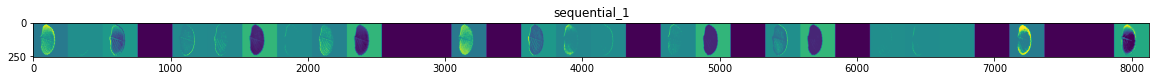

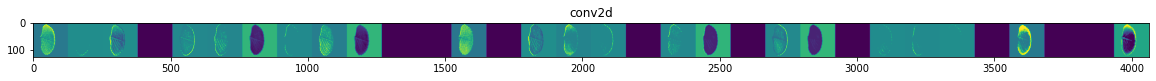

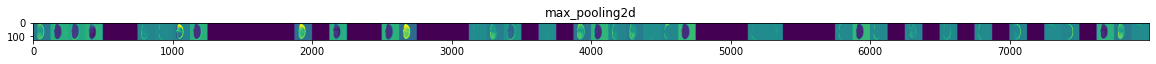

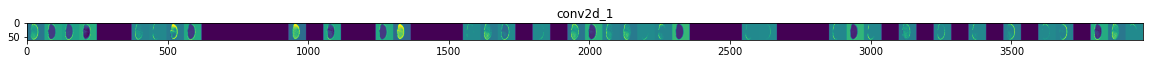

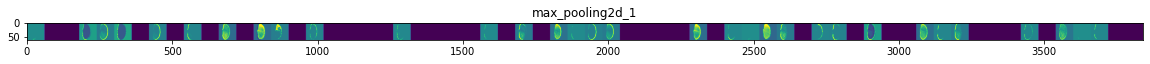

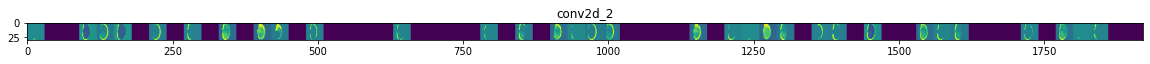

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np
import matplotlib.pyplot as plt
x = []
img='/content/drive/MyDrive/PlantVillage/Train/Plectranthus Amboinicus (Mexican Mint)/PA-S-001.jpg'
img = cv2.imread(img)
img = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
processImg = removeBlurr(img)
processImg = segment_image(processImg)
processImg = sharpen_image(processImg)
processImg = cv2.cvtColor(processImg,cv2.COLOR_RGB2GRAY)
processImg = np.reshape(processImg,(256,256,1))
#cv2_imshow(cv2.cvtColor(processImg, cv2.COLOR_BGR2RGB))
# x_train.append(processImg)
processImg = np.concatenate((np.array(img),np.array(processImg)),axis=2)
rgb = rgba2rgb(np.array(processImg))
# ridges = detect_ridges(rgb)
x.append(rgb)
x = np.array(x)
# Let's run input image through our vislauization network
# to obtain all intermediate representations for the image.
successive_outputs = [layer.output for layer in model.layers[1:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

successive_feature_maps = visualization_model.predict(x)
# Retrieve are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]
# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
figNum = 0
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)
  if len(feature_map.shape) == 4:
    
    #-------------------------------------------
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    #-------------------------------------------
    n_features = feature_map.shape[-1]  # number of features in the feature map
    size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
    
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    
    #-------------------------------------------------
    # Postprocess the feature to be visually palatable
    #-------------------------------------------------
    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid


    #-----------------
    # Display the grid
    #-----------------

    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto' ) 
    # plt.savefig(f'/content/drive/MyDrive/PlantVillage/Features/feature{figNum}PA-S-001.jpg.png', dpi=500)
    figNum +=1



### Test Camera

In [ ]:
vid = cv2.VideoCapture(0)

while(True):
      
    # Capture the video frame
    # by frame
    ret, frame = vid.read()
  
    # Display the resulting frame
    cv2_imshow(frame)
      
    # the 'q' button is set as the
    # quitting button you may use any
    # desired button of your choice
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
  
# After the loop release the cap object
vid.release()
# Destroy all the windows
cv2.destroyAllWindows()

AttributeError: ignored